## Preparing data

In [1]:
import xarray as xr
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from datetime import datetime, timedelta
from functools import partial
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
import numpy as np
import glob
import dask.array as da
import pandas as pd
from dask_jobqueue import SLURMCluster

In [2]:
year = 2010

In [3]:
parent_in_path = f"/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data"
data_paths = {
            "era5land": f"{parent_in_path}/{year}global/era5land/*u_component*-01*.nc",
            "lai": f"{parent_in_path}/{year}global/lai_v2/*.nc",
            "ssm": f"{parent_in_path}/{year}global/ssm/GlobalGSSM11km2014_20240214.tif",
            "co2": f"{parent_in_path}/{year}global/co2/CAMS_CO2_2003-2020.nc",
            "landcover": f"{parent_in_path}/landcover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7cds.nc",
            "vcmax": f"{parent_in_path}/Vcmax/TROPOMI_Vmax_Tg_mean.tif",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmGlobal20240215.tif",
            }

In [4]:
def era5_preprocess(ds):    
    # Convert the longitude coordinates from [0, 360] to [-180, 180]
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    
    return ds

def fix_coords(ds):
    if 'band' in ds.dims:
        ds = ds.rename_dims({'band': 'time'})
        ds = ds.rename_vars({'band': 'time'})

    if 'x' in ds.dims and 'y' in ds.dims:
        ds = ds.rename_dims({'x': 'longitude', 'y': 'latitude'})
        ds = ds.rename_vars({'x': 'longitude', 'y': 'latitude'})
        
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename_dims({'lon': 'longitude', 'lat': 'latitude'})
        ds = ds.rename_vars({'lon': 'longitude', 'lat': 'latitude'})
    return ds

In [24]:
cluster = SLURMCluster(
    name='dask-worker',
    cores=16,
    processes=16,
    queue='fat',
    memory='120GiB',
    local_directory='$TMPDIR',
    walltime='4:00:00'
)
cluster.scale(jobs=4)
client = Client(cluster)
# print(client,flush=True)
# print(client.dashboard_link,flush=True)
client

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38143 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/38143/status,
Dashboard: /proxy/38143/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://145.136.63.37:36227,Workers: 0
Dashboard: /proxy/38143/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
era5land_old = xr.open_mfdataset(data_paths['era5land'], preprocess=era5_preprocess, chunks={'longitude': 250, 'latitude': 250})
# era5land = era5land.chunk({'time': 750})
era5land_old = era5land_old.sortby(['longitude', 'latitude'])
era5land_old = era5land_old.chunk(
    time=750, 
    longitude=250, 
    latitude=250
)
# era5land_old = era5land_old.sel(time="2010-01-01T00:00:00.000000000")
# era5land_old.u10.attrs = {}
# era5land_old = era5land_old.isel(longitude=slice(0, 250),latitude=slice(0, 250))

In [98]:
import netCDF4

# 打开 NetCDF3 文件
nc3 = netCDF4.Dataset('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5-land_10m_u_component_of_wind_2010-01.nc')
print(nc3.variables["u10"].chunking())  # 检查分块方式

# 打开 NetCDF4 文件
nc4 = netCDF4.Dataset("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/0scripts_download/era5-land_10m_u_component_of_wind_2010-01.nc")
print(nc4.variables["u10"].chunking())


None
[68, 164, 328]


In [7]:
era5land = xr.open_mfdataset("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/0scripts_download/era5-land_10m_u_component_of_wind_2010-01.nc", preprocess=era5_preprocess, chunks={'longitude': 250, 'latitude': 250})
# era5land = era5land.chunk({'time': 750})
era5land = era5land.sortby(['longitude', 'latitude'])
era5land = era5land.chunk(
    valid_time=750, 
    longitude=250, 
    latitude=250
)
# era5land = era5land.sel(valid_time="2010-01-01T00:00:00.000000000")
era5land=era5land.drop_vars(['number','expver'])
# era5land.u10.attrs = {}

In [35]:
era5land_old.u10[10,0,0].values

array(-2.5185657, dtype=float32)

In [36]:
era5land.u10[10,0,0].values

array(-2.5183716, dtype=float32)

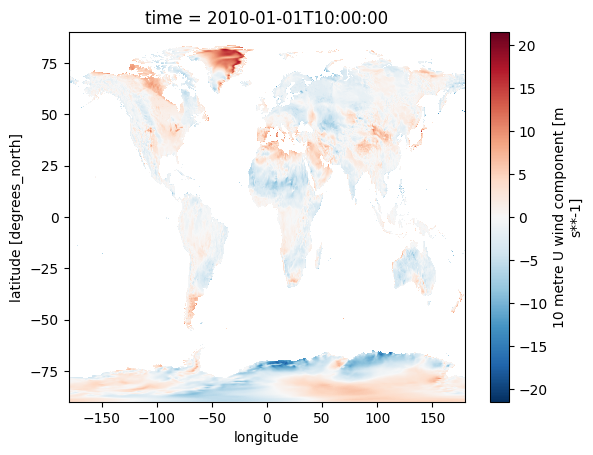

In [31]:
era5land_old.u10[10].plot()

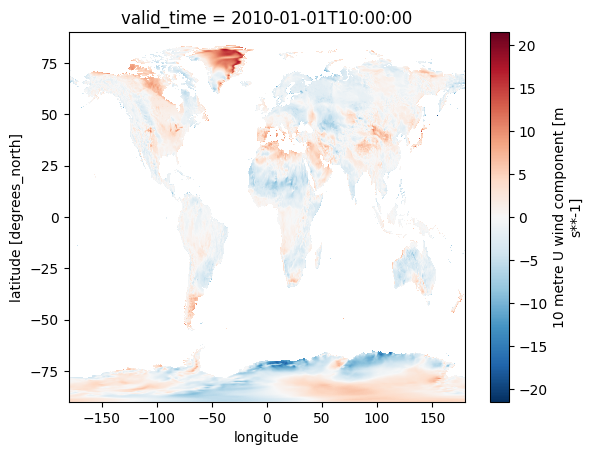

In [32]:
era5land.u10[10].plot()

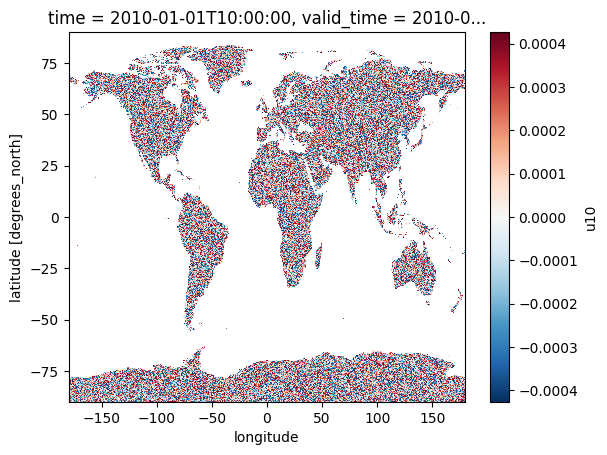

In [18]:
(era5land_old.u10[10]-era5land.u10[10]).plot()

In [30]:
(era5land_old.u10[10]-era5land.u10[10]).sum().compute()

<xarray.DataArray 'u10' ()>
array(-0.07083809, dtype=float32)
Coordinates:
    time        datetime64[ns] 2010-01-01T10:00:00
    valid_time  datetime64[ns] 2010-01-01T10:00:00

In [10]:
era5land.u10.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 1,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (68, 164, 328),
 'source': '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/0scripts_download/era5-land_10m_u_component_of_wind_2010-01.nc',
 'original_shape': (744, 1801, 3600),
 'dtype': dtype('float32'),
 '_FillValue': nan,
 'coordinates': 'number valid_time latitude longitude expver'}

In [28]:
era5land = era5land.assign_coords(
    latitude=era5land.latitude.astype('float32'),
    longitude=era5land.longitude.astype('float32')
)


In [29]:
# 创建新的经度坐标，减去 0.1
new_longitude = era5land.longitude - 0.1

# 创建一个新的 DataArray，并用新的经度坐标
era5land_new = era5land.assign_coords(longitude=new_longitude)

In [86]:
era5land_old.u10

<xarray.DataArray 'u10' (time: 744, latitude: 1801, longitude: 3600)>
dask.array<rechunk-merge, shape=(744, 1801, 3600), dtype=float32, chunksize=(744, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude   (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [87]:
era5land_new.u10

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'u10' (valid_time: 744, latitude: 1801, longitude: 3600)>
dask.array<rechunk-merge, shape=(744, 1801, 3600), dtype=float32, chunksize=(744, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
  * latitude    (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude   (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Attributes:
    GRIB_paramId:                             165
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_uvRelativeToGrid:                    0
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1801
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           u10
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        0.1
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.1
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.9
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                10 metre U wind component
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [46]:
# era5land_new['u10'] = era5land_old.u10

In [88]:
%%time
# # svae to zarr
out_path = f"{parent_in_path}/{year}global/era5land/{'era5land'}_{year}2025windCompress.zarr"
encoding = {var: {"compressor": None} for var in era5land_old.data_vars}
era5land_old.to_zarr(out_path, mode='w')#,encoding=encoding)

CPU times: user 15.2 s, sys: 874 ms, total: 16.1 s
Wall time: 1min 13s


In [89]:
%%time
# # svae to zarr
out_path = f"{parent_in_path}/{year}global/era5land/{'era5land'}_{year}2025windNewCompress.zarr"
encoding = {var: {"compressor": None} for var in era5land_new.data_vars}
era5land_new.to_zarr(out_path, mode='w')#,encoding=encoding)

CPU times: user 4.63 s, sys: 300 ms, total: 4.93 s
Wall time: 17.4 s


In [33]:
client.shutdown()

In [15]:
import zarr
z1 = xr.open_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025wind.zarr')
z2 = xr.open_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windNew.zarr')


In [ ]:
(z1.u10 - z2.u10).plot()

In [25]:
z2.u10

<xarray.DataArray 'u10' (valid_time: 744, latitude: 1801, longitude: 3600)>
dask.array<open_dataset-847ff5d400b67f78a174ae10a0fe483bu10, shape=(744, 1801, 3600), dtype=float32, chunksize=(744, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude   (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * valid_time  (valid_time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
Attributes:
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1801
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           u10
    GRIB_dataType:                            fc
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_gridType:                            regular_ll
    GRIB_iDirectionIncrementInDegrees:        0.1
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.1
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.9
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                10 metre U wind component
    GRIB_numberOfPoints:                      6483600
    GRIB_paramId:                             165
    GRIB_shortName:                           10u
    GRIB_stepType:                            instant
    GRIB_stepUnits:                           1
    GRIB_surface:                             0.0
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m s**-1
    GRIB_uvRelativeToGrid:                    0
    coordinates:                              number valid_time latitude long...
    long_name:                                10 metre U wind component
    standard_name:                            unknown
    units:                                    m s**-1

In [21]:
compressor = zarr.Blosc(cname='lz4', clevel=5, shuffle=2, blocksize=0)
encoding = {var: {"compressor": compressor} for var in z1.data_vars}
z1.to_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr', mode='w',encoding=encoding)

In [6]:
compressor = zarr.Blosc(cname='lz4', clevel=5, shuffle=2, blocksize=0)
encoding = {var: {"compressor": compressor} for var in z2.data_vars}
z2.to_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windNewTest.zarr', mode='w',encoding=encoding)

In [17]:
! du -h $'/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr'

2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr/latitude
6.0G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr/u10
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr/time
6.0G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2010global/era5land/era5land_20102025windTest.zarr


In [93]:
# 查看每个变量的压缩信息
for var in z1.data_vars:
    print(f"Variable: {var}")
    print(z1[var].encoding.get("compressor"))

Variable: u10
Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


In [92]:
# 查看每个变量的压缩信息
for var in z2.data_vars:
    print(f"Variable: {var}")
    print(z2[var].encoding.get("compressor"))

Variable: u10
Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


In [72]:
z1.u10

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'u10' (time: 744, latitude: 1801, longitude: 3600)>
dask.array<open_dataset-e67af58a58881ff49f57e3006bb22e65u10, shape=(744, 1801, 3600), dtype=float32, chunksize=(744, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
Attributes:
    long_name:  10 metre U wind component
    units:      m s**-1

In [73]:
z2.u10

<xarray.DataArray 'u10' (valid_time: 744, latitude: 1801, longitude: 3600)>
dask.array<open_dataset-847ff5d400b67f78a174ae10a0fe483bu10, shape=(744, 1801, 3600), dtype=float32, chunksize=(744, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude   (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * valid_time  (valid_time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
Attributes:
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1801
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           u10
    GRIB_dataType:                            fc
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_gridType:                            regular_ll
    GRIB_iDirectionIncrementInDegrees:        0.1
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.1
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.9
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                10 metre U wind component
    GRIB_numberOfPoints:                      6483600
    GRIB_paramId:                             165
    GRIB_shortName:                           10u
    GRIB_stepType:                            instant
    GRIB_stepUnits:                           1
    GRIB_surface:                             0.0
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m s**-1
    GRIB_uvRelativeToGrid:                    0
    coordinates:                              number valid_time latitude long...
    long_name:                                10 metre U wind component
    standard_name:                            unknown
    units:                                    m s**-1